# Welcome to the airport climatology tutorial!

<img align="center" width="800" src="https://a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2019/11/931/524/RT-Lightning.jpg?ve=1&tl=1">

### This tutorial will explore the occurance of deep convection (thunderstorms) using 10 years of data from ERA5 reanalysis and weather radar, and also provide a comparision to demonstrate the usefulness of radar observation. Why is this important?

<img align="center" width="800" src="https://www.bne.com.au/sites/default/files/BAC3747-Thunderstorm%20Infographic%20Animation%201140x1325px%20v1.gif">

As you can see, when there is a storm within a 10 nautical mile radius, an airport is placed on alert, and when a storm is within 5 nautical miles, airport operations are suspended.

Ideally, airports should be constructed in areas that minimise local thunderstorm activity. This is not only because thunderstorms are dangerous for airport staff and passengers, but also because suspended operations can cost airports and airlines many millions per year in extra costs due to fuel and staffing. Ever had a flight delayed or cancelled due to weather? It can cost you a lot of time and effort too! Ideally, airports and airlines can optimise operations schdules around climatological peak periods of thunderstorm activity.

The following tutorial will explore the thunderstorm climatology for Melbourne, Brisbane and Sydney Airports, and the new Western Sydney airport location, from the persecptive of ERA5 and weather radar so we can make our own assessments.

<img align="center" width="500" src="img/airport_table.png">

Before this can be done, we will first run over the preprocessing of these datasets. Preprocessing is essential here as the end-use datasets (only a few MB) are sourced from many tens of gigabytes of underlying data.

First, jump to the preprocessing [ERA5 processing script](./preprocessing_scripts/preprocess_era5.ipynb)

Second, jump to the preprocessing [Weather radar processing script](./preprocessing_scripts/preprocess_radar.ipynb)

In [29]:
#import ususal suspects for data analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
#define which airports to investigate
airport_name_list = ['MEL','SYD','WSYD','BNE']

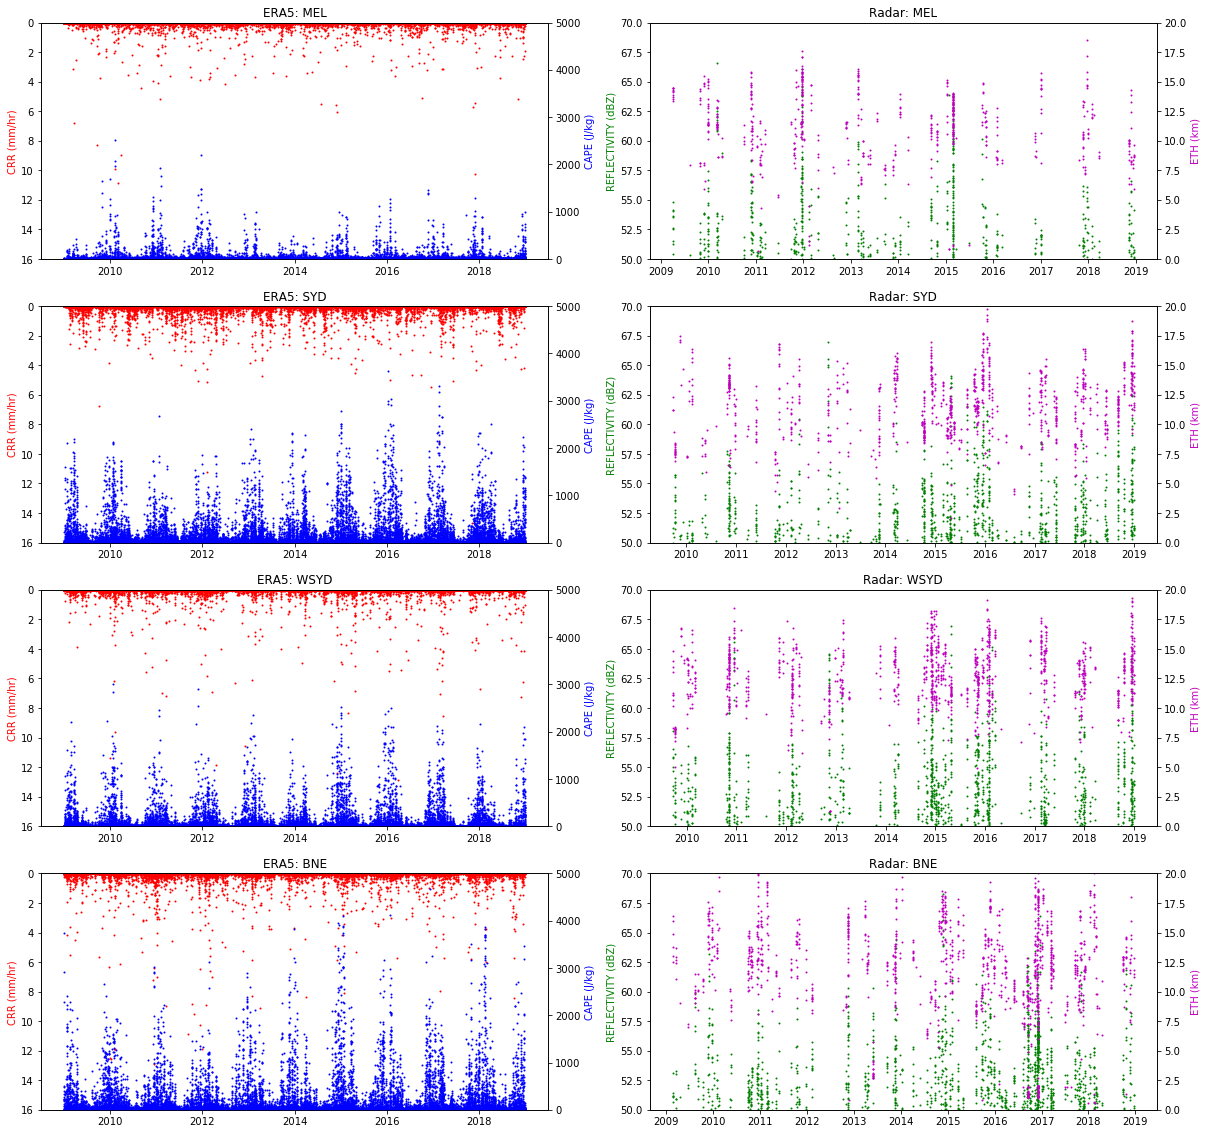

In [89]:
number_airports = len(airport_name_list)
fig, axes = plt.subplots(nrows=number_airports, ncols=2, figsize=(20, 5*number_airports))

for i, airport_name in enumerate(airport_name_list):
    #load preprocessed data from numpyz files for both ERA5 and Weather radar
    with np.load('preprocessed_data/{name}_era5.npz'.format(name=airport_name)) as era_dict:
        era5_time = era_dict['era5_time']
        era5_crr  = era_dict['era5_crr']*60*60 #crr is in units of mm/s (kg/m2/s)
        era5_cape = era_dict['era5_cape']
    with np.load('preprocessed_data/{name}_radar.npz'.format(name=airport_name)) as radar_dict:
        radar_time = radar_dict['radar_time']
        radar_ref  = radar_dict['radar_ref']
        radar_eth  = radar_dict['radar_eth']
        
    #plot ERA5 data
    ax1 = axes[i,0]
    ax2 = ax1.twinx()
    ax1.plot(era5_time, era5_crr, 'r.', ms=2) 
    ax2.plot(era5_time, era5_cape, 'b.', ms=2)
    ax1.set_ylabel('CRR (mm/hr)', color='r')
    ax2.set_ylabel('CAPE (J/kg)', color='b')
    ax1.set_ylim((16,0))
    ax2.set_ylim((0,5000))
    ax1.set_title('ERA5: ' + airport_name)
    
    
    #plot radar data
    ax1 = axes[i,1]
    ax2 = ax1.twinx()
    ax1.plot(radar_time, radar_ref, 'g.', ms=2)
    ax2.plot(radar_time, radar_eth/1000, 'm.', ms=2)
    ax1.set_ylabel('REFLECTIVITY (dBZ)', color='g')
    ax2.set_ylabel('ETH (km)', color='m')
    ax1.set_ylim((50,70))
    ax2.set_ylim((0,20))
    ax1.set_title('Radar: ' + airport_name)

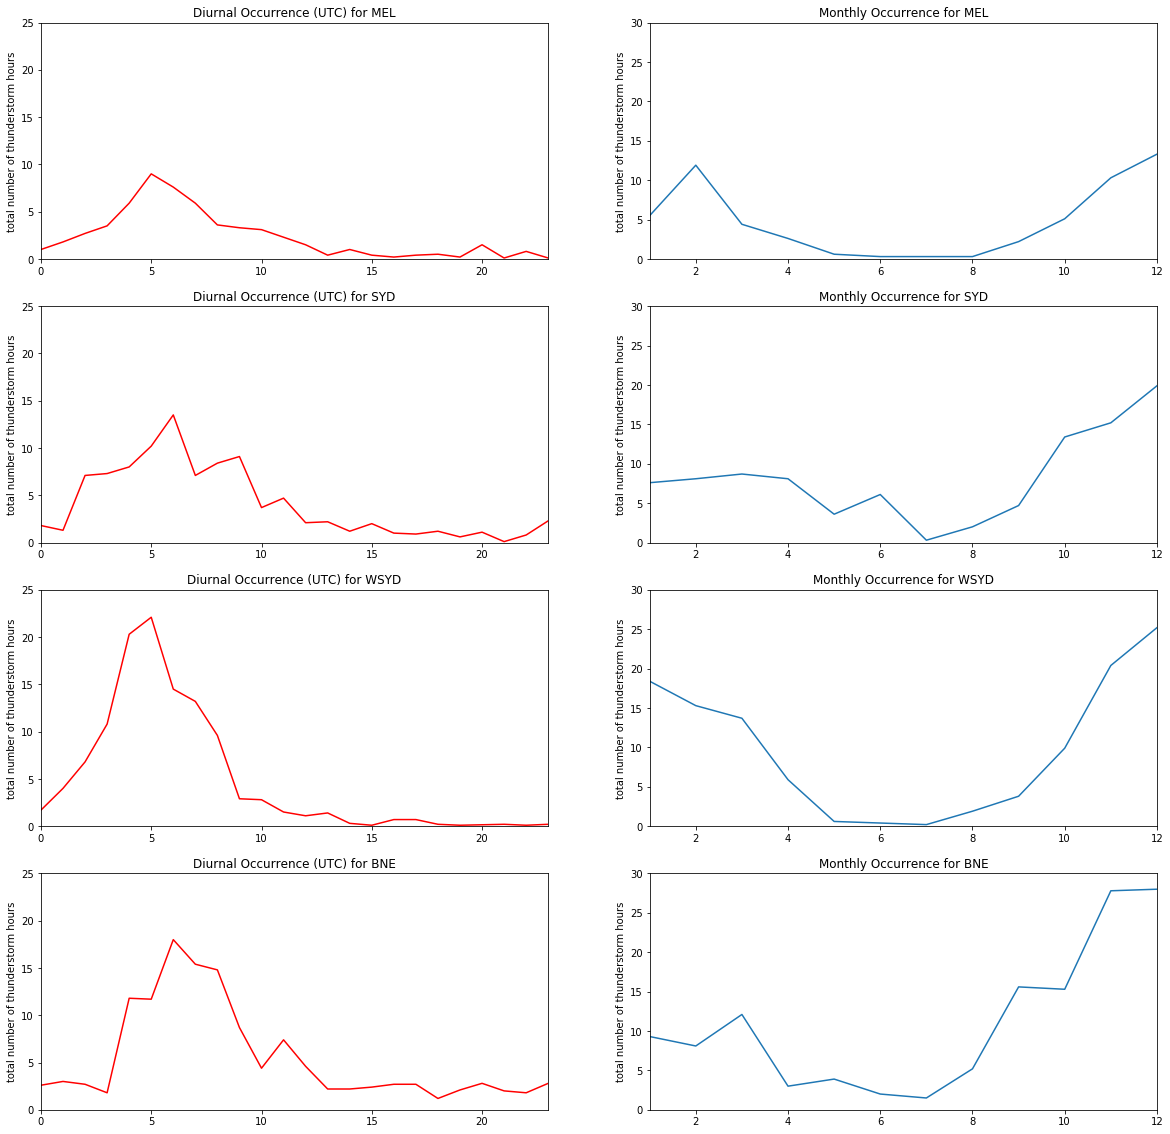

In [135]:
#lets now produce diurnal and seasonal plots of the weather radar and ERA5 data to understand the climatology better

number_airports = len(airport_name_list)
fig, axes = plt.subplots(nrows=number_airports, ncols=2, figsize=(20, 5*number_airports))

for i, airport_name in enumerate(airport_name_list):
    
    #load preprocessed data from numpyz files for both ERA5 and Weather radar
    with np.load('preprocessed_data/{name}_radar.npz'.format(name=airport_name)) as radar_dict:
        radar_time = radar_dict['radar_time']
        radar_ref  = radar_dict['radar_ref']
        radar_eth  = radar_dict['radar_eth']

    radar_df = pd.DataFrame({'ref':radar_ref, 'eth':radar_eth,'time':radar_time})  #index
    
    count_multiplier = 0.1

    radar_df.groupby(radar_df['time'].dt.hour)['ref'].count().mul(count_multiplier).plot(style='r', ax=axes[i,0])
    axes[i,0].set_title('Diurnal Occurrence (UTC) for ' + airport_name)
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel('total number of thunderstorm hours')
    axes[i,0].set_xlim((0,23))
    axes[i,0].set_ylim((0,25))
    
    out = radar_df.groupby(radar_df['time'].dt.month)['ref'].count().mul(count_multiplier).plot(ax=axes[i,1])
    axes[i,1].set_title('Monthly Occurrence for ' + airport_name)
    axes[i,1].set_xlabel('')
    axes[i,1].set_ylabel('total number of thunderstorm hours')
    axes[i,1].set_xlim((1,12))
    axes[i,1].set_ylim((0,30))

Looks ok! Clear annual cycle in both ERA and weather radar data with a peak around summer for all airports.
Remember that each data point in the ERA5 represents a 31 km grid, while the weather radar data indicates a thunderstorm without our 16 km search radius

Let's now reseample weather radar timeseries to use the same 3hrly timestep as ERA5. This will be more useful for explore whether environments in ERA5 reflect the observed thunderstorms

In [131]:
# what's left to do: show poor performance of ERA5 (CAPE), breifly explain why
# inegrate two exercises: one for students to look at plots of seasonal intensity and CTH?

#Plots to look at ERA5 + radar again.

#pandas can do this with ease!

#first, we need to pad our data to the time range of the era5 data
radar_time_pad = np.concatenate(([era5_time[0]], radar_time, [era5_time[-1]]))
radar_ref_pad = np.concatenate(([np.nan], radar_ref, [np.nan]))
radar_eth_pad = np.concatenate(([np.nan], radar_eth, [np.nan]))

#second, we need to create a pandas dataframe of our radar data
radar_df = pd.DataFrame({'ref':radar_ref_pad, 'eth':radar_eth_pad},    # values
                    index=radar_time_pad)  #index
print(radar_df)

#now we can resample to 3hourly intervals
radar_df_3hr = radar_df.resample('3H').mean()
print(radar_df_3hr)

#and convert back to numpy arrays
radar_ref_3hrly = radar_df_3hr['ref'][:]
radar_eth_3hrly = radar_df_3hr['eth'][:]
radar_time_3hrly = radar_df_3hr.index

                           ref           eth
2009-01-01 00:00:00        NaN           NaN
2009-02-19 08:00:30  51.421875  12992.007812
2009-02-19 08:06:29  51.156250  13814.234375
2009-02-19 08:12:29  50.687500  14877.453125
2009-02-19 08:18:29  51.187500  12546.976562
...                        ...           ...
2018-12-21 08:00:31  51.273438  12886.921875
2018-12-21 08:06:28  50.148438  11847.406250
2018-12-21 08:12:28  50.359375  11501.562500
2018-12-21 08:18:28  51.273438  11252.929688
2018-12-31 21:00:00        NaN           NaN

[1320 rows x 2 columns]
                     ref  eth
2009-01-01 00:00:00  NaN  NaN
2009-01-01 03:00:00  NaN  NaN
2009-01-01 06:00:00  NaN  NaN
2009-01-01 09:00:00  NaN  NaN
2009-01-01 12:00:00  NaN  NaN
...                  ...  ...
2018-12-31 09:00:00  NaN  NaN
2018-12-31 12:00:00  NaN  NaN
2018-12-31 15:00:00  NaN  NaN
2018-12-31 18:00:00  NaN  NaN
2018-12-31 21:00:00  NaN  NaN

[29216 rows x 2 columns]


253


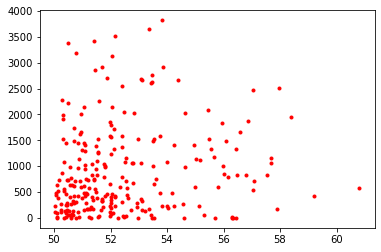

In [132]:
print(np.sum(~np.isnan(radar_ref_3hrly)))

plt.plot(radar_ref_3hrly,era5_cape, 'r.')

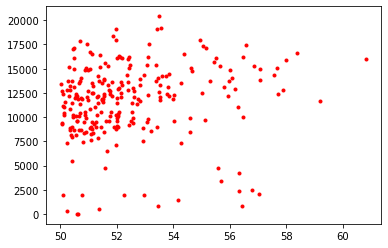

In [69]:
plt.plot(radar_ref_3hrly,radar_eth_3hrly, 'r.')